In [1]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import torch
import astroddpm
import tqdm

## Relative imports
from astroddpm.runners import Diffuser, config_from_id, get_samples
from astroddpm.analysis.validationMetrics import powerSpectrum, minkowskiFunctional, basics
from astroddpm.analysis import overfitting_check
from astroddpm.utils.plot import check_nearest_epoch, plot_losses, check_training_samples, plot_comparaison
from astroddpm.diffusion.dm import DiscreteSBM
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE
from astroddpm.diffusion.models.network import ResUNet
import astroddpm.utils.colormap_custom 

In [2]:
from cmb_hmc.cmb_ps import CMBPS, unnormalize_phi, normalize_phi
from cmb_hmc.hmc_torch import HMC

In [3]:
## 0.2 0.4 0.6 0.8 
phi_target_0_list = [0.2, 0.4, 0.6, 0.8]
phi_target_1_list = [0.2, 0.4, 0.6, 0.8]

phi_list_list = []

for phi_target_0 in phi_target_0_list:
    for phi_target_1 in phi_target_1_list:
        phi_list_list.append(torch.load('phi_list_{}_{}.pt'.format(f'{phi_target_0:.2f}', f'{phi_target_1:.2f}')))

In [4]:
phi_list_list[0].shape

torch.Size([4000, 16, 2])

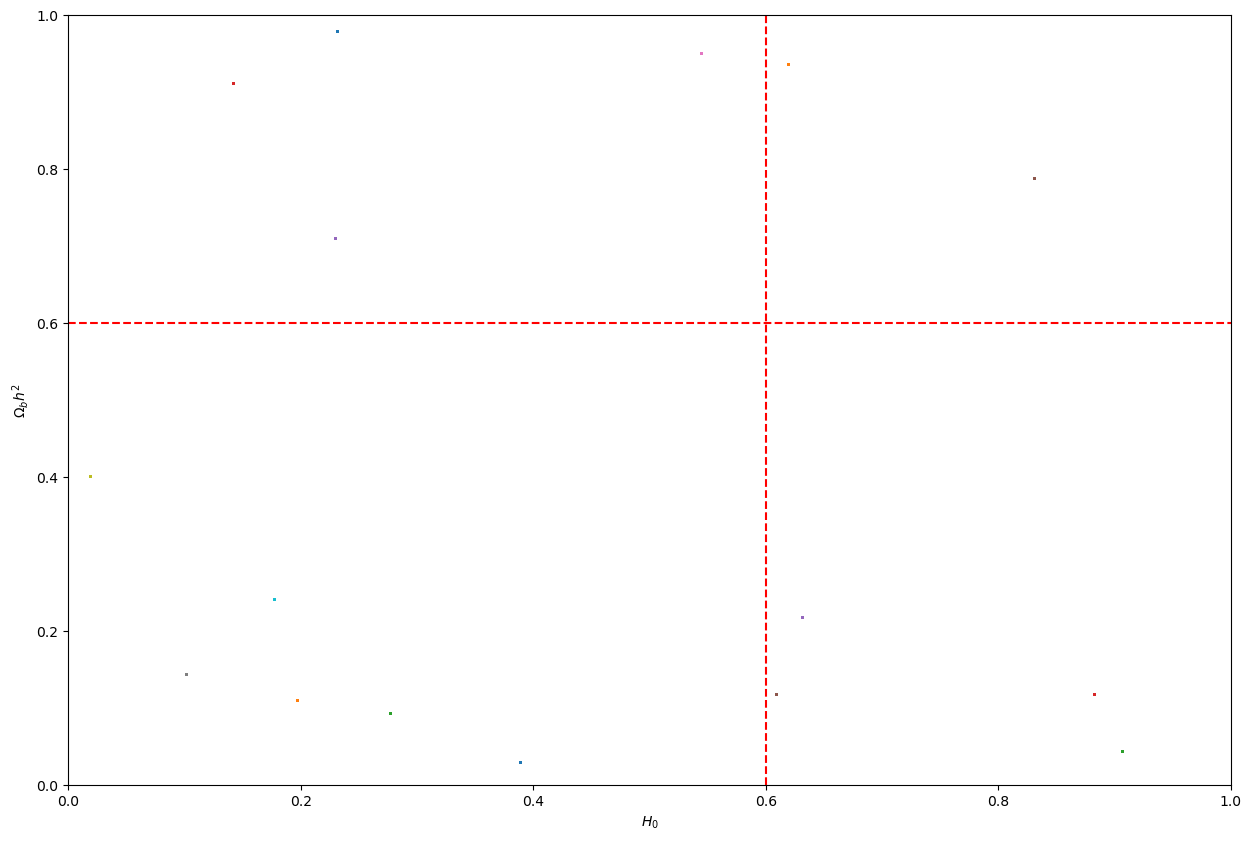

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
for i in range(phi_list_list[10].shape[1]):
    ax.scatter(phi_list_list[10][:, i, 0].detach().cpu().numpy(), phi_list_list[10][:,i, 1].detach().cpu().numpy(), s=0.5, alpha=0.5)
ax.axvline(0.6, color='red', linestyle='--')
ax.axhline(0.6, color='red', linestyle='--')
plt.xlabel(r"$H_0$")
plt.ylabel(r"$\Omega_b h^2$")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
amin = - 3
amax = 3

MODEL_ID = 'DiscreteSBM_MultiSigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_32_firstc_20_invsqrt'

In [7]:
placeholder_dm = DiscreteSBM(DiscreteVPSDE(1000), ResUNet())
diffuser = Diffuser(placeholder_dm)
diffuser.load(config=config_from_id(MODEL_ID), also_ckpt=True, for_training=True)

No model id found
Loading the diffuser from a config dict.
Loading the optimizer and scheduler states from the checkpoint, as well as previous training info. You should change the model id if you want to finetune the model.


In [8]:
batch = next(iter(diffuser.test_dataloader))
image = batch.unsqueeze(1).to(device)[:1]

In [9]:
theta_target = diffuser.diffmodel.ps.sample_theta(100).mean(dim = 0, keepdim=True).to(device)
ps = diffuser.diffmodel.ps(theta_target)
rtheta_target = diffuser.diffmodel.ps.rescale_theta(theta_target)
sq_ps = torch.sqrt(ps).to(device)
theta_target = theta_target.to(device)
noisy, mean, noise = diffuser.diffmodel.sde.sampling(image, 100, sq_ps)

In [10]:
NUM_CHAIN = 16

In [11]:
batch = image.repeat(NUM_CHAIN, 1, 1, 1)
ps_0, thetas_0 = diffuser.diffmodel.ps.sample_ps(NUM_CHAIN)
batch_mean = mean.repeat(NUM_CHAIN, 1, 1, 1)
noisy_batch = noisy.repeat(NUM_CHAIN, 1, 1, 1)

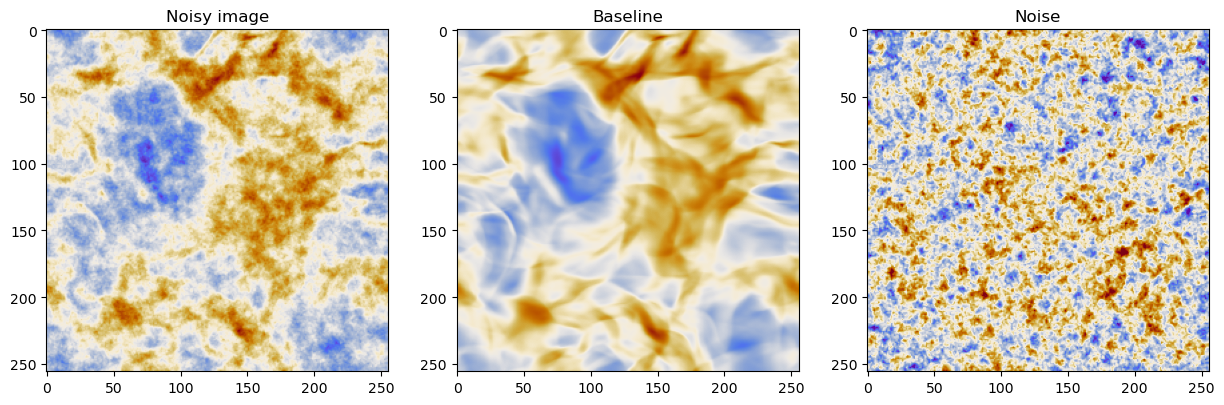

In [12]:
## Plot the noisy image along with the noise and baseline
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(noisy[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=3)
ax[0].set_title('Noisy image')
ax[1].imshow(batch[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=3)
ax[1].set_title('Baseline')
ax[2].imshow(noise[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=3)
ax[2].set_title('Noise')
plt.show()

In [49]:
N_GIBBS = 20
BURNIN_GIBBS = 0
N_HMC = 100

timesteps = 100 * torch.ones(NUM_CHAIN, dtype=torch.int32).to(device)

In [50]:
def sample_prior(n):
    """
    Sample from the (normalized) prior distribution.
    phi = (H0, Obh2) with H0 ~ U(0, 1), Obh2 ~ U(0, 1)
    (unnormalized prior is H0 ~ U(50, 90), Obh2 ~ U(0.0075, 0.0567))
    """
    phi = torch.rand(n, 2).to(device)
    return phi

ps_model = CMBPS(norm_phi=True).to(device)

In [51]:
def log_likelihood(phi, x):
    """
    Compute the log likelihood of the Gaussian model.
    """
    x_dim = x.shape[-1]*x.shape[-2]

    ps = ps_model(phi)
    xf = torch.fft.fft2(x)

    term_pi = -(x_dim/2) * np.log(2*np.pi)
    term_logdet = -1/2*torch.sum(torch.log(ps), dim=(-1, -2, -3)) # The determinant is the product of the diagonal elements of the PS
    term_x = -1/2*torch.sum(1/ps*torch.abs(xf)**2, dim=(-1, -2, -3))/x_dim # We divide by x_dim because of the normalization of the FFT

    return term_pi + term_logdet + term_x

def log_prior(phi):
    """
    Compute the log (normalized) prior of the parameters.
    """
    H0, Obh2 = phi[..., 0], phi[..., 1]
    term_H0 = torch.log(torch.logical_and(H0 >= 0.0, H0 <= 1.0).float())
    term_Obh2 = torch.log(torch.logical_and(Obh2 >= 0.0, Obh2 <= 1.0).float())
    return term_H0 + term_Obh2

def log_posterior(phi, x):
    """
    Compute the log posterior of the parameters (not normalized by the evidence).
    """
    return log_likelihood(phi, x) + log_prior(phi)

In [52]:
theta_list = []
phi_list = []
rescaled_batch = diffuser.diffmodel.sde.rescale_preserved_to_additive(noisy_batch, timesteps)

In [86]:
""" Adapted from https://github.com/modichirag/VBS/blob/main/src/pyhmc.py """

class Sampler():

    def __init__(self):
        self.samples = []
        self.accepts = []
        self.Hs = []
        self.counts = []
        self.i = 0

    def to_tensor(self):
        for key in self.__dict__:
            if isinstance(self.__dict__[key], list):
                dim_per_key = {'samples': -2, 'accepts': -1, 'Hs': -2, 'counts': -2}
                self.__dict__[key] = torch.stack(self.__dict__[key], dim=dim_per_key[key])

    def to_list(self):
        for key in self.__dict__:
            if isinstance(self.__dict__[key], torch.Tensor):
                self.__dict__[key] = self.__dict__[key].tolist()

    def appends(self, q, acc, Hs, count):
        self.i += 1
        self.accepts.append(acc)
        self.samples.append(q)
        self.Hs.append(Hs)
        self.counts.append(count)
        
    def save(self, path):
        pass

class DualAveragingStepSize():
    def __init__(self, initial_step_size, target_accept=0.65, gamma=0.05, t0=10.0, kappa=0.75, nadapt=0, nchains=1):
        self.initial_step_size = initial_step_size
        self.mu = torch.log(10 * initial_step_size)   # proposals are biased upwards to stay away from 0.
        self.target_accept = target_accept
        self.gamma = gamma
        self.t = t0
        self.kappa = kappa
        self.error_sum = 0
        self.log_averaged_step = 0
        self.nadapt = nadapt
        
    def update(self, p_accept):
        p_accept[p_accept > 1] = 1.
        p_accept[torch.isnan(p_accept)] = 0.
        print("P accept : ", p_accept)
        # Running tally of absolute error. Can be positive or negative. Want to be 0.
        self.error_sum += self.target_accept - p_accept
        print("Error sum : ", self.error_sum)
        # This is the next proposed (log) step size. Note it is biased towards mu.
        log_step = self.mu - self.error_sum / (np.sqrt(self.t) * self.gamma)
        print("Log step : ", log_step)
        # Forgetting rate. As `t` gets bigger, `eta` gets smaller.
        eta = self.t ** -self.kappa
        # Smoothed average step size
        self.log_averaged_step = eta * log_step + (1 - eta) * self.log_averaged_step
        print("Log averaged step : ", self.log_averaged_step)
        # This is a stateful update, so t keeps updating
        self.t += 1

        # Return both the noisy step size, and the smoothed step size
        return torch.exp(log_step), torch.exp(self.log_averaged_step)

    
    def __call__(self, i, p_accept):
        if i == 0:
            return self.initial_step_size 
        elif i < self.nadapt:
            step_size, avgstepsize = self.update(p_accept)
        elif i == self.nadapt:
            _, step_size = self.update(p_accept)
            print("\nStep size fixed to : %0.3e\n" % step_size)
        else:
            step_size = torch.exp(self.log_averaged_step)
        return step_size
    


class HMC():

    def __init__(self, log_prob, grad_log_prob=None, log_prob_and_grad=None, invmetric_diag=None, precision=torch.float32):

        self.precision = precision

        self.log_prob, self.grad_log_prob = log_prob, grad_log_prob
        self.log_prob_and_grad = log_prob_and_grad

        # Convert to precision
        if self.log_prob is not None:
            self.log_prob = lambda x: log_prob(x).to(self.precision)
        if self.grad_log_prob is not None:
            self.grad_log_prob = lambda x: grad_log_prob(x).to(self.precision)
        if self.log_prob_and_grad is not None:
            self.log_prob_and_grad = lambda x: tuple([y.to(self.precision) for y in log_prob_and_grad(x)])

        if invmetric_diag is None:
            self.invmetric_diag = 1.
        else:
            self.invmetric_diag = invmetric_diag
        self.metricstd = self.invmetric_diag**-0.5

        assert not((self.grad_log_prob is None) and (self.log_prob_and_grad is None))

        self.V = lambda x: -self.log_prob(x)
        self.KE = lambda p: 0.5*(p**2 * self.invmetric_diag).sum(-1) #Sum across rows
        self.KE_g = lambda p: p * self.invmetric_diag

        self.leapcount = 0
        self.Vgcount = 0
        self.Hcount = 0

    def V_g(self, x):
        self.Vgcount += 1
        if self.grad_log_prob is not None:
            v_g = self.grad_log_prob(x)
        elif self.log_prob_and_grad is not None:
            v, v_g = self.log_prob_and_grad(x)
        return -v_g

    def V_vandg(self, x):
        if self.log_prob_and_grad is not None:
            self.Vgcount += 1
            v, v_g = self.log_prob_and_grad(x)
            return -v, -v_g
        else:
            raise NotImplementedError

    def unit_norm_KE(self, p):
        return 0.5 * (p**2).sum(-1) #sum across rows

    def unit_norm_KE_g(self, p):
        return p

    def H(self, q, p, Vq=None):
        if Vq is None:
            self.Hcount += 1
            Vq = self.V(q)
        return Vq + self.KE(p)

    def leapfrog(self, q, p, N, step_size):
        self.leapcount += 1
        q0, p0 = q, p
        try:
            p = p - 0.5 * step_size.reshape(-1,1) * self.V_g(q)
            for i in range(N - 1):
                q = q + step_size.reshape(-1,1) * self.KE_g(p)
                p = p - step_size.reshape(-1,1) * self.V_g(q)
            q = q + step_size.reshape(-1,1) * self.KE_g(p)
            p = p - 0.5 * step_size.reshape(-1,1)* self.V_g(q)
            return q, p

        except Exception as e:
            print("exception_leapfrog : ", e)
            return q0, p0

    def leapfrog_Vgq(self, q, p, N, step_size, V_q=None, V_gq=None):
        self.leapcount += 1
        q0, p0, V_q0, V_gq0 = q, p, V_q, V_gq
        try:
            if V_gq is None:
                p = p - 0.5 * step_size * self.V_g(q)
            else:
                p = p - 0.5 * step_size * V_gq
            for i in range(N - 1):
                q = q + step_size * self.KE_g(p)
                p = p - step_size * self.V_g(q)

            q = q + step_size * self.KE_g(p)
            if self.log_prob_and_grad is not None:
                V_q1, V_gq1 = self.V_vandg(q)
            else:
                V_q1, V_gq1 = None, self.V_g(q)
            p = p - 0.5 * step_size * V_gq1
            return q, p, V_q1, V_gq1

        except Exception as e:
            print("exception_leapfrog_Vgq : ", e)
            return q0, p0, V_q0, V_gq0
        
    def metropolis(self, qp0, qp1, V_q0=None, V_q1=None, u=None):
        
        q0, p0 = qp0
        q1, p1 = qp1
        H0 = self.H(q0, p0, V_q0)
        H1 = self.H(q1, p1, V_q1)
        prob = torch.exp(H0 - H1)

        if u is None:
            u = torch.rand(prob.shape[0], device=prob.device)

        qq = q1.clone()
        pp = p1.clone()
        acc = torch.ones_like(prob)

        cond1 = torch.logical_or(torch.isnan(prob), torch.isinf(prob))
        cond1 = torch.logical_or(cond1, torch.sum(q0 - q1, dim=-1) == 0)

        qq[cond1] = q0[cond1]
        pp[cond1] = p0[cond1]
        acc[cond1] = -1.0

        cond2 = torch.logical_and(u > torch.min(torch.ones_like(u), prob), ~cond1)
        qq[cond2] = q0[cond2]
        pp[cond2] = p0[cond2]
        acc[cond2] = 0.0
        
        return qq, pp, acc, torch.stack([H0, H1], dim=-1)

    def step(self, q, nleap, step_size, **kwargs):

        self.leapcount, self.Vgcount, self.Hcount = 0, 0, 0
        p = torch.randn(q.shape, device=q.device, dtype=self.precision) * self.metricstd
        q1, p1 = self.leapfrog(q, p, nleap, step_size)
        q, p, accepted, Hs = self.metropolis([q, p], [q1, p1])
        return q, p, accepted, Hs, torch.tensor([self.Hcount, self.Vgcount, self.leapcount])

    def _parse_kwargs_sample(self, **kwargs):

        self.nsamples = kwargs['nsamples']
        self.burnin = kwargs['burnin']
        self.step_size = kwargs['step_size']
        self.nleap = kwargs['nleap']

    def adapt_stepsize(self, q, epsadapt, **kwargs):
        print("Adapting step size for %d iterations" % epsadapt)
        self._parse_kwargs_sample(**kwargs)
        step_size = self.step_size * torch.ones(q.shape[0], device=q.device, dtype=self.precision)
        epsadapt_kernel = DualAveragingStepSize(step_size)

        for i in range(epsadapt + 1):
            q, p, acc, Hs, count = self.step(q, self.nleap, step_size)
            prob = torch.exp(Hs[:,0] - Hs[:,1])
            if i < epsadapt:
                prob[torch.isnan(prob)] = 0.
                prob[prob > 1] = 1.
                print('former step size:', step_size)
                step_size, avgstepsize = epsadapt_kernel.update(prob)
                print('new step size:', step_size)
            elif i == epsadapt:
                _, step_size = epsadapt_kernel.update(prob)
                print("Step size fixed to : ", step_size)
                self.step_size = step_size
        return q
    
    def sample(self, q, p=None, callback=None, skipburn=True, verbose = True, epsadapt=0, **kwargs):
        if q.ndim == 1: q = q.unsqueeze(0) # Q must be at least 2D
        assert q.ndim == 2, "q must be 2D"

        q = q.to(self.precision)

        kw = kwargs
        self._parse_kwargs_sample(**kwargs)
        
        state = Sampler()
        if epsadapt:
            q = self.adapt_stepsize(q, epsadapt, **kwargs)
            
        for i in tqdm.tqdm(range(self.nsamples + self.burnin), disable=not verbose):
            q, p, acc, Hs, count = self.step(q, self.nleap, self.step_size)
            state.i += 1
            state.accepts.append(acc)
            if skipburn & (i >= self.burnin):
                state.samples.append(q)
                state.Hs.append(Hs)
                state.counts.append(count)
                if callback is not None: callback(state)
        state.to_tensor()
        return state


In [87]:
thetas = thetas_0.clone()
progress_bar = tqdm.tqdm(range(N_GIBBS+BURNIN_GIBBS))
for n in range(N_GIBBS+BURNIN_GIBBS):
    X_0, _ = diffuser.diffmodel.generate_image(NUM_CHAIN, sample = noisy_batch, initial_timestep=100, verbose=False, thetas = thetas)
    ps = diffuser.diffmodel.ps(thetas)
    sq_ps = torch.sqrt(ps).to(device)
    _, mean, _ = diffuser.diffmodel.sde.sampling(X_0, 100, sq_ps)
    epsilon_hat = (rescaled_batch - mean)/diffuser.diffmodel.sde.noise_level(timesteps)
    log_prob = lambda phi: log_posterior(phi, epsilon_hat)
    def log_prob_grad(phi):
        """
        Compute the log posterior and its gradient.
        """
        log_prob = log_posterior(phi, epsilon_hat)
        grad_log_prob = torch.autograd.grad(log_prob, phi, grad_outputs=torch.ones_like(log_prob))[0]
        return log_prob, grad_log_prob
    hmc = HMC(log_prob, log_prob_and_grad=log_prob_grad)
    if n < 1:
        kwargs = {'nsamples': 1,
          'burnin': 0,
          'step_size': 5e-6,
          'nleap': 0}
        epsadapt = 5
    else:
        kwargs = {'nsamples': 1,
          'burnin': 0,
          'step_size': step_size,
          'nleap': 20}
        epsadapt = 0

    phi_0 = sample_prior(NUM_CHAIN).requires_grad_()
    phi_0 = phi_list[-1].requires_grad_() if len(phi_list) > 0 else phi_0
    sampler = hmc.sample(phi_0, epsadapt = epsadapt, verbose = False, **kwargs)
    step_size = hmc.step_size
    phi = sampler.samples[:,-1]
    phi_list.append(phi) 
    thetas = unnormalize_phi(phi)
    theta_list.append(thetas)
    thetas.detach()
    thetas.requires_grad_()
    progress_bar.update(1)
    

  5%|▌         | 1/20 [00:33<10:43, 33.88s/it]


Adapting step size for 5 iterations
tensor([3.7155e+00, 4.7707e+00, 3.6011e+00, 2.8936e+00, 2.4750e+00, 2.9854e+00,
        6.8832e-04, 3.3830e+00, 2.3056e-04, 1.8108e+00, 5.7546e+00, 4.3438e+00,
        2.5536e+00, 1.3668e+00, 3.1780e+00, 2.7183e+00], device='cuda:0',
       grad_fn=<ExpBackward0>)
former step size: tensor([5.0000e-06, 5.0000e-06, 5.0000e-06, 5.0000e-06, 5.0000e-06, 5.0000e-06,
        5.0000e-06, 5.0000e-06, 5.0000e-06, 5.0000e-06, 5.0000e-06, 5.0000e-06,
        5.0000e-06, 5.0000e-06, 5.0000e-06, 5.0000e-06], device='cuda:0')
Error sum :  tensor([-0.3500, -0.3500, -0.3500, -0.3500, -0.3500, -0.3500,  0.6493, -0.3500,
         0.6498, -0.3500, -0.3500, -0.3500, -0.3500, -0.3500, -0.3500, -0.3500],
       device='cuda:0', grad_fn=<AddBackward0>)
Log step :  tensor([ -7.6899,  -7.6899,  -7.6899,  -7.6899,  -7.6899,  -7.6899, -14.0101,
         -7.6899, -14.0130,  -7.6899,  -7.6899,  -7.6899,  -7.6899,  -7.6899,
         -7.6899,  -7.6899], device='cuda:0', grad_fn=<Su

  5%|▌         | 1/20 [00:02<00:54,  2.87s/it]

tensor([inf, 0., 0., inf, inf, inf, inf, inf, inf, inf, inf, 0., inf, inf, inf, inf],
       device='cuda:0', grad_fn=<ExpBackward0>)
Error sum :  tensor([-0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1007, -0.1000,
        -0.1002, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000, -0.1000],
       device='cuda:0', grad_fn=<AddBackward0>)
Log step :  tensor([-9.3871, -9.3871, -9.3871, -9.3871, -9.3871, -9.3871, -9.3835, -9.3871,
        -9.3859, -9.3871, -9.3871, -9.3871, -9.3871, -9.3871, -9.3871, -9.3871],
       device='cuda:0', grad_fn=<SubBackward0>)
Log averaged step :  tensor([-4.9269, -4.2852, -4.2852, -4.9269, -4.9269, -6.1061, -7.1500, -4.9269,
        -7.1516, -6.6454, -4.9269, -4.2852, -4.9269, -6.1061, -6.1061, -4.9269],
       device='cuda:0', grad_fn=<AddBackward0>)
Step size fixed to :  tensor([0.0072, 0.0138, 0.0138, 0.0072, 0.0072, 0.0022, 0.0008, 0.0072, 0.0008,
        0.0013, 0.0072, 0.0138, 0.0072, 0.0022, 0.0022, 0.0072],
       device='cuda:0', gr

KeyboardInterrupt: 

In [68]:
tensor_phi_list = [phi.unsqueeze(0) for phi in phi_list]

In [69]:
tensor_phi_list = torch.cat(tensor_phi_list, dim=0)

In [70]:
tensor_phi_list.shape

torch.Size([60, 16, 2])

In [71]:
phi_test = normalize_phi(theta_target)

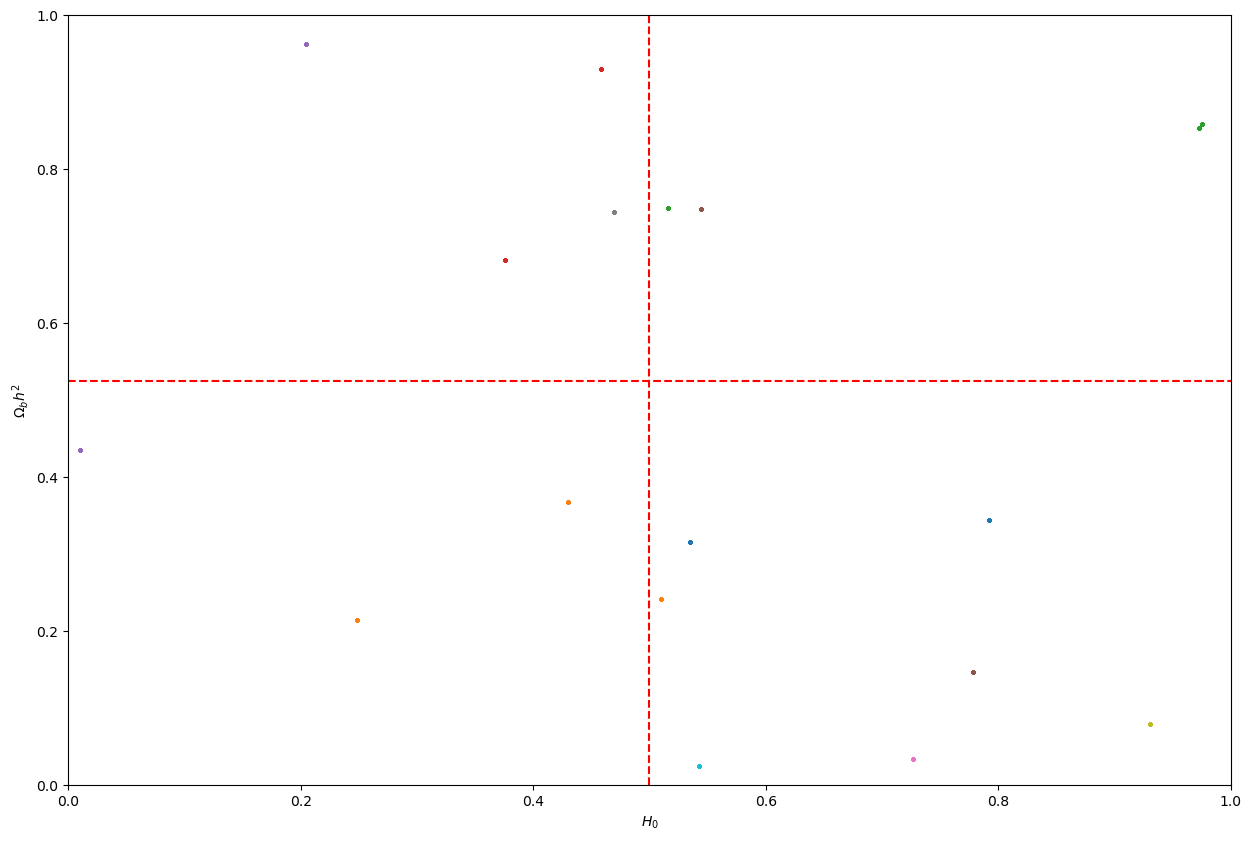

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
for i in range(tensor_phi_list.shape[1]):
    ax.scatter(tensor_phi_list[:, i, 0].detach().cpu().numpy(), tensor_phi_list[:,i, 1].detach().cpu().numpy(), s=4, alpha=0.5)
ax.axvline(phi_test[0,0].detach().cpu().numpy(), color='red', linestyle='--')
ax.axhline(phi_test[0,1].detach().cpu().numpy(), color='red', linestyle='--')
plt.xlabel(r"$H_0$")
plt.ylabel(r"$\Omega_b h^2$")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

Code for log likelihood landscaped plotting

In [23]:
def log_likelihood(phi, x):
    """
    Compute the log likelihood of the Gaussian model.
    """
    x_dim = x.shape[-1]*x.shape[-2]

    ps = ps_model(phi)
    xf = torch.fft.fft2(x)

    term_pi = -(x_dim/2) * np.log(2*np.pi)
    term_logdet = -1/2*torch.sum(torch.log(ps), dim=(-1, -2)) # The determinant is the product of the diagonal elements of the PS
    term_x = -1/2*torch.sum(1/ps*torch.abs(xf)**2, dim=(-1, -2))/x_dim # We divide by x_dim because of the normalization of the FFT

    return term_pi, term_logdet, term_x, term_x + term_logdet + term_pi

def log_prior(phi):
    """
    Compute the log (normalized) prior of the parameters.
    """
    H0, Obh2 = phi[..., 0], phi[..., 1]
    term_H0 = torch.log(torch.logical_and(H0 >= 0.0, H0 <= 1.0).float())
    term_Obh2 = torch.log(torch.logical_and(Obh2 >= 0.0, Obh2 <= 1.0).float())
    return term_H0 + term_Obh2

def log_posterior(phi, x):
    """
    Compute the log posterior of the parameters (not normalized by the evidence).
    """
    return log_likelihood(phi, x) + log_prior(phi)

In [24]:
phi_0 = normalize_phi(thetas_0)
phi_target = normalize_phi(theta_target)

/mnt/sw/nix/store/pvz51gzx2lyqpabf08xhd1y2kvw5rfdy-python-3.9.16-view/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /dev/shm/nix-build-py-torch-2.0.1.drv-2/nixbld2/spack-stage-py-torch-2.0.1-mz6i5h51yxg23diix2nxgr73s62pzclc/spack-src/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


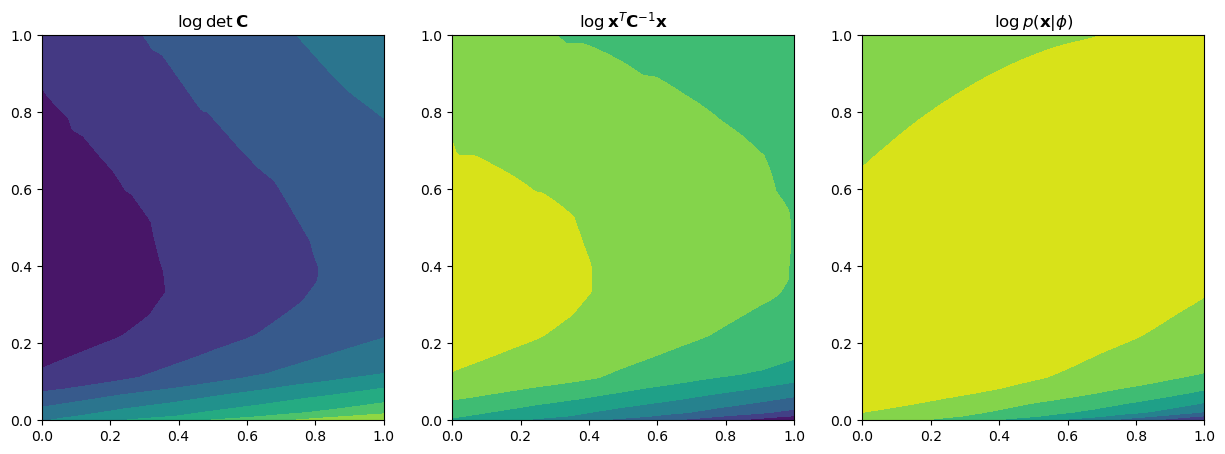

ValueError: 

In [25]:
## Compute the log posterior for the observation and the first image on a grid of value for phi and plot it
H0 = torch.linspace(0, 1, 100)
Obh2 = torch.linspace(0, 1, 100)
H0_grid, Obh2_grid = torch.meshgrid(H0, Obh2)
phi_grid = torch.stack([H0_grid, Obh2_grid], dim=-1).to(device)
_, logdet_grid, logtermx_grid, log_likelihood_grid = log_likelihood(phi_grid.reshape(-1,2), epsilon_hat[:1])
logdet_grid = logdet_grid.reshape(100, 100)
logtermx_grid = logtermx_grid.reshape(100, 100)
log_likelihood_grid = log_likelihood_grid.reshape(100, 100)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].contourf(H0_grid.cpu().numpy(), Obh2_grid.cpu().numpy(), logdet_grid.cpu().numpy())
ax[0].set_title(r"$\log \det \mathbf{C}$")
ax[1].contourf(H0_grid.cpu().numpy(), Obh2_grid.cpu().numpy(), logtermx_grid.cpu().numpy())
ax[1].set_title(r"$\log \mathbf{x}^T \mathbf{C}^{-1} \mathbf{x}$")
ax[2].contourf(H0_grid.cpu().numpy(), Obh2_grid.cpu().numpy(), log_likelihood_grid.cpu().numpy())
ax[2].set_title(r"$\log p(\mathbf{x} | \phi)$")
plt.show()
raise ValueError

plt.contourf(H0_grid.cpu().numpy(), Obh2_grid.cpu().numpy(), log_posterior_grid.cpu().numpy())
plt.axvline(phi_0[0,0].detach().cpu().numpy(), color='red', linestyle='--')
plt.axhline(phi_0[0,1].detach().cpu().numpy(), color='red', linestyle='--')
plt.axhline(phi_target[0,1].detach().cpu().numpy(), color='green', linestyle='--')
plt.axvline(phi_target[0,0].detach().cpu().numpy(), color='green', linestyle='--')
plt.xlabel(r"$H_0$")
plt.ylabel(r"$\Omega_b h^2$")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.colorbar()
plt.show()


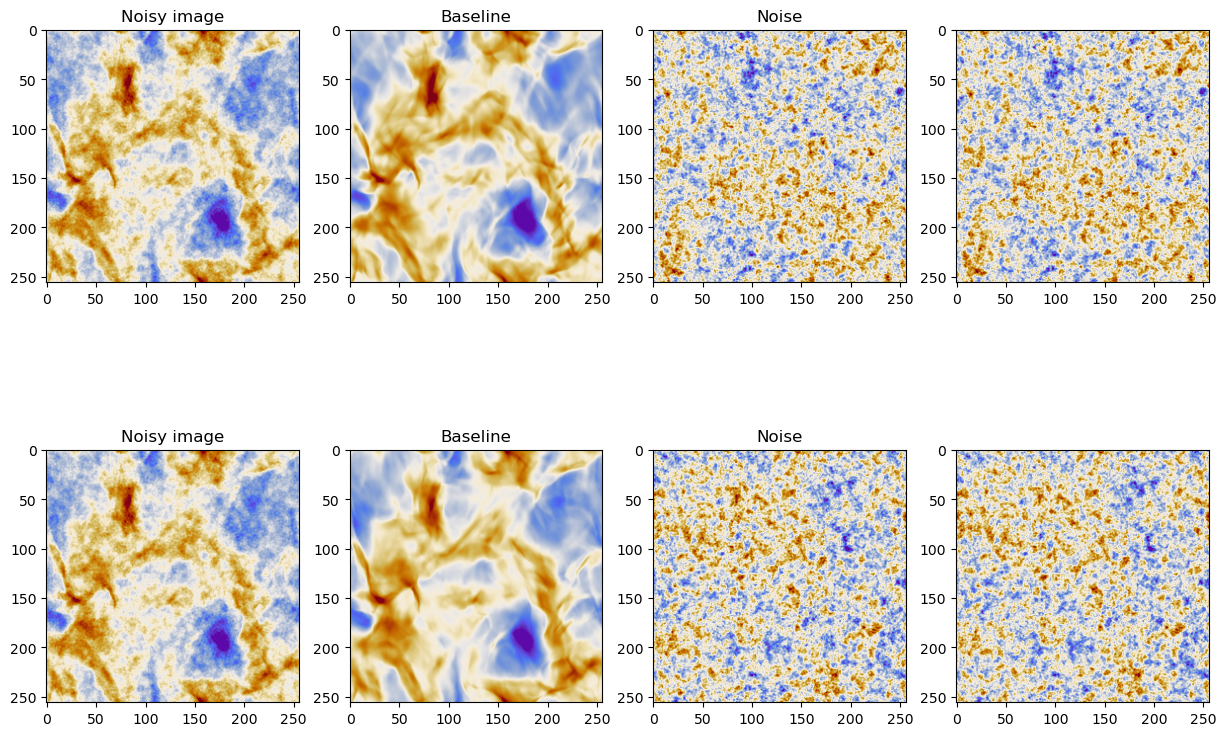

In [ ]:
## Plot the noisy image along with the noise and baseline
fig, ax = plt.subplots(2, 4, figsize=(15, 10))
ax[0,0].imshow(noisy[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=3)
ax[0,0].set_title('Noisy image')
ax[0,1].imshow(batch[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=3)
ax[0,1].set_title('Baseline')
ax[0,2].imshow(noise[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=3)
ax[0,2].set_title('Noise')
ax[0,3].imshow(((diffuser.diffmodel.sde.rescale_preserved_to_additive(noisy, timesteps)-batch)/diffuser.diffmodel.sde.noise_level(timesteps))[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=3)

ax[1,0].imshow(noisy[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=3)
ax[1,0].set_title('Noisy image')
ax[1,1].imshow(X_0[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=3)
ax[1,1].set_title('Baseline')
ax[1,2].imshow(epsilon_hat[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=3)
ax[1,2].set_title('Noise')
ax[1,3].imshow(((diffuser.diffmodel.sde.rescale_preserved_to_additive(noisy, timesteps)-X_0)/diffuser.diffmodel.sde.noise_level(timesteps))[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=3)

plt.show()